<a href="https://colab.research.google.com/github/milanfx/DTSA-5506/blob/main/5506_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting California Housing Prices Using Ensemble Models

---
# 1. Introduction

## 1.1 Back Ground

- Kaggle Competition Hosted by D2L
- Predicting California House Prices
- Evaluated by RMSE of Log Predictions

## 1.2 Data Source

- Real-world Data Scraped from Zillow.com
- Including Errors and Noises
- Training 2020 all Data to Predict 2021


## 1.3 Project Objectives

- Extracting the Feature Correlations
- Improving Model Performance
- Surpassing the #1 Score


---
# 2. Exploratory Data Analysis

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [ ]:
train_link = "https://drive.google.com/uc?id=1yHzaSQmjICd4mhXWVNTlMxl5kZldrFiy"
test_link = "https://drive.google.com/uc?id=114bWJwKf9hZ2dMAHLsNbTUTPP4pGFH2U"

train = pd.read_csv(train_link)
test = pd.read_csv(test_link)
total = pd.concat([train, test], axis=0)

print("train",train.shape)
print("test",test.shape)
print("total",total.shape)

train (47439, 41)
test (31626, 40)
total (79065, 41)


In [ ]:
total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 79065 entries, 0 to 31625
Data columns (total 41 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Id                           79065 non-null  int64  
 1   Address                      79065 non-null  object 
 2   Sold Price                   47439 non-null  float64
 3   Summary                      78226 non-null  object 
 4   Type                         79065 non-null  object 
 5   Year built                   77123 non-null  float64
 6   Heating                      67552 non-null  object 
 7   Cooling                      63956 non-null  object 
 8   Parking                      77389 non-null  object 
 9   Lot                          56076 non-null  float64
 10  Bedrooms                     74467 non-null  object 
 11  Bathrooms                    73655 non-null  float64
 12  Full bathrooms               66137 non-null  float64
 13  Total interior l

## 2.1 Features Information

## 2.2 Data Correlation

In [ ]:
# Correlation - With Outliers
train_data = train.copy()
train_data['Bedrooms'] = pd.to_numeric(train_data['Bedrooms'], errors='coerce')
numeric_features = train_data.select_dtypes(include=[float])
# Caculate Corr + Mean
correlation = round(numeric_features.corrwith(train_data['Sold Price']).sort_values(ascending=False),4)
mean_values = round(numeric_features.mean(),1)
print(pd.DataFrame({'Correlation': correlation.values, 'Mean': mean_values[correlation.index]}))

                             Correlation       Mean
Sold Price                        1.0000  1296050.5
Annual tax amount                 0.7462     9956.8
Tax assessed value                0.7432   786311.8
Last Sold Price                   0.7068   807853.7
Listed Price                      0.6127  1315890.3
Full bathrooms                    0.5442        2.1
Bathrooms                         0.5162        2.4
Bedrooms                          0.3069        3.0
Elementary School Score           0.2756        5.7
Middle School Score               0.2443        5.3
High School Score                 0.1916        6.1
Garage spaces                     0.0093        1.5
Total spaces                      0.0075        1.6
Total interior livable area      -0.0015     5774.6
Lot                              -0.0066   235338.3
Year built                       -0.0271     1956.6
Middle School Distance           -0.0593        1.7
Elementary School Distance       -0.0862        1.2
High School 

In [ ]:
# Correlation - Without Outliers by Z-score
# Remove Outliers as Nan
mean_values = train_data.select_dtypes(include=[float]).mean()
std_values = train_data.select_dtypes(include=[float]).std()
lower_limit = mean_values - 3 * std_values
upper_limit = mean_values + 3 * std_values
numeric_features = train_data.select_dtypes(include=[float])
numeric_features[(numeric_features < lower_limit) | (numeric_features > upper_limit)] = np.nan
# Caculate Corr + Mean
correlation = round(numeric_features.corrwith(train_data['Sold Price']).sort_values(ascending=False),4)
mean_values = round(numeric_features.mean(),1)
print(pd.DataFrame({'Correlation': correlation.values, 'Mean': mean_values[correlation.index]}))

                             Correlation       Mean
Sold Price                        1.0000  1175553.3
Listed Price                      0.8128  1207590.9
Last Sold Price                   0.6284   736396.0
Annual tax amount                 0.5545     8959.9
Tax assessed value                0.5502   702650.4
Bathrooms                         0.3916        2.3
Full bathrooms                    0.3750        2.0
Bedrooms                          0.3008        2.9
Elementary School Score           0.2756        5.7
Total interior livable area       0.2486     1846.7
Middle School Score               0.2443        5.3
High School Score                 0.1916        6.1
Garage spaces                     0.0560        1.4
Total spaces                      0.0393        1.4
Lot                              -0.0106    51034.9
Middle School Distance           -0.0110        1.4
Year built                       -0.0155     1966.1
Elementary School Distance       -0.0626        0.9
High School 

- The idea is to primarily use "Listed Price" as the main predictor for estimating "Sold Price" and employ other features to adjust the result and improve the accuracy.

## 2.3 Estimating "Sold Price" by "Listed Price"

In [ ]:
# Using "Listed Price" as "Sold Price" with only change < 100000
estimation = test[['Id', 'Listed Price']].copy()
estimation.rename(columns={'Listed Price': 'Sold Price'}, inplace=True)
estimation['Sold Price'] = estimation['Sold Price'].apply(lambda x: 160000 if x < 100000 else x)

estimation.to_csv('estimation.csv', index=False)  # 保存为 predicted_results.csv 文件

- The Score is 0.15498  
- The Ranking is #44 from 173 Teams

---
# 3. Data Cleaning - Categorical Features

In [ ]:
# Count the Unique Numbers for Each Categorical Feature
total1 = total.copy()
columns_to_check = ['Type', 'Flooring', 'Heating features', 'Cooling features', 'Laundry features', 'Parking features', 'Appliances included']

for column in columns_to_check:
    unique_count = total1[column].nunique()
    print(f"{column}: {unique_count} unique values")

Type: 174 unique values
Flooring: 1739 unique values
Heating features: 1762 unique values
Cooling features: 595 unique values
Laundry features: 3030 unique values
Parking features: 9694 unique values
Appliances included: 11289 unique values


### 3.1 House Type

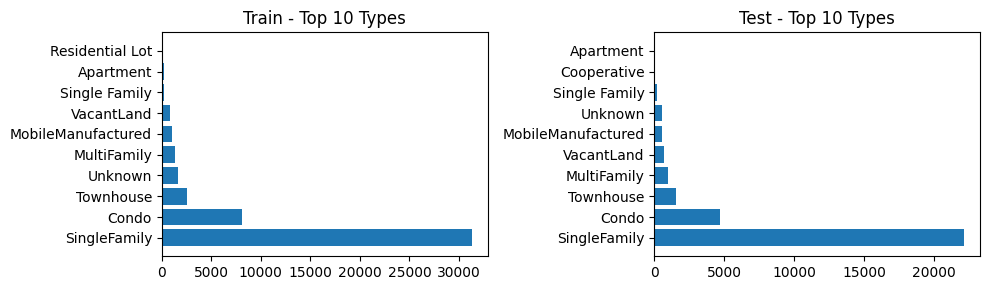

In [ ]:
plt.figure(figsize=(10, 3))
feature = 'Type'

train_counts = train[feature].value_counts().head(10)
test_counts = test[feature].value_counts().head(10)

plt.subplot(121); plt.barh(train_counts.index, train_counts.values); plt.title(f'Train - Top 10 {feature}s')
plt.subplot(122); plt.barh(test_counts.index, test_counts.values); plt.title(f'Test - Top 10 {feature}s')
plt.tight_layout();plt.show()

In [ ]:
# Clean Types - Top 6 Types and Others
total1['Type'] = total1['Type'].str.replace('Single Family', 'SingleFamily')
total1['Type'] = total1['Type'].str.replace('Vacant Land', 'VacantLand')
total1['Type'] = total1['Type'].str.replace('Apartment', 'Condo')
valid_type = ["SingleFamily", "Condo", "Townhouse", "MultiFamily", "MobileManufactured", "VacantLand"]
total1["Type"] = total1["Type"].apply(lambda x: x if x in valid_type else "Other")

df_type = pd.DataFrame()
df_type['Counts'] = total1['Type'].value_counts()
df_type['List Mean'] = round(total1.groupby('Type')['Listed Price'].mean(),0)
df_type['List Std'] = round(total1.groupby('Type')['Listed Price'].std(),0)
print(df_type)

                    Counts  List Mean   List Std
SingleFamily         53883  1246957.0  1867873.0
Condo                12985   844486.0   651180.0
Townhouse             4096   877867.0   432215.0
Other                 2746  1490888.0  7835953.0
MultiFamily           2258  1175922.0  1033628.0
MobileManufactured    1577   281375.0   162844.0
VacantLand            1520   727923.0  1740573.0


### 3.2 Flooring

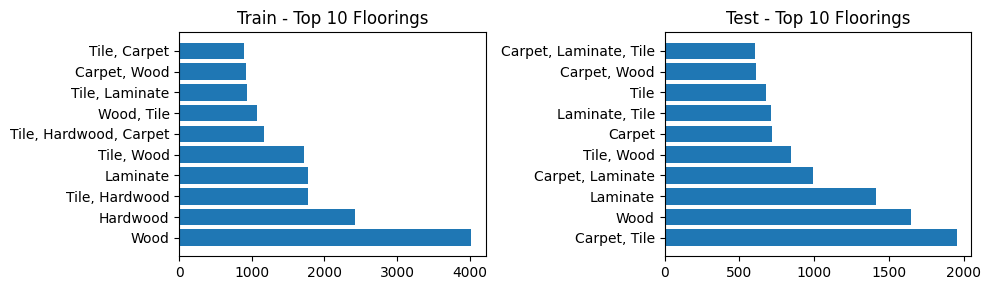

In [ ]:
plt.figure(figsize=(10, 3))
feature = 'Flooring'

train_counts = train[feature].value_counts().head(10)
test_counts = test[feature].value_counts().head(10)

plt.subplot(121); plt.barh(train_counts.index, train_counts.values); plt.title(f'Train - Top 10 {feature}s')
plt.subplot(122); plt.barh(test_counts.index, test_counts.values); plt.title(f'Test - Top 10 {feature}s')
plt.tight_layout();plt.show()

In [ ]:
# Clean Flooring - First Description
total1['Flooring'] = total1['Flooring'].str.title()
total1['Flooring'] = total1['Flooring'].str.split(r'[, /-]').str[0]
valid_flooring = ["Carpet", "Tile", "Wood", "Laminate", "Hardwood", "Vinyl", "Concrete", "Bamboo", "Stone"]
total1["Flooring"] = total1["Flooring"].apply(lambda x: x if x in valid_flooring else "Other")

df_flooring = pd.DataFrame()
df_flooring['Counts'] = total1['Flooring'].value_counts()
df_flooring['List Mean'] = round(total1.groupby('Flooring')['Listed Price'].mean(),0)
df_flooring['List Std'] = round(total1.groupby('Flooring')['Listed Price'].std(),0)
print(df_flooring)

          Counts  List Mean   List Std
Other      24410   972365.0  3016866.0
Carpet     16572   931364.0  1383008.0
Tile       15152  1343177.0  1240591.0
Wood        9017  1599525.0  2165513.0
Laminate    6146   710233.0   465174.0
Hardwood    5580  1633469.0  2491957.0
Vinyl        755   698598.0   436608.0
Concrete     565   846598.0  1003186.0
Bamboo       447  1010564.0   685358.0
Stone        421  2775513.0  4769043.0


### 3.3 Heating features

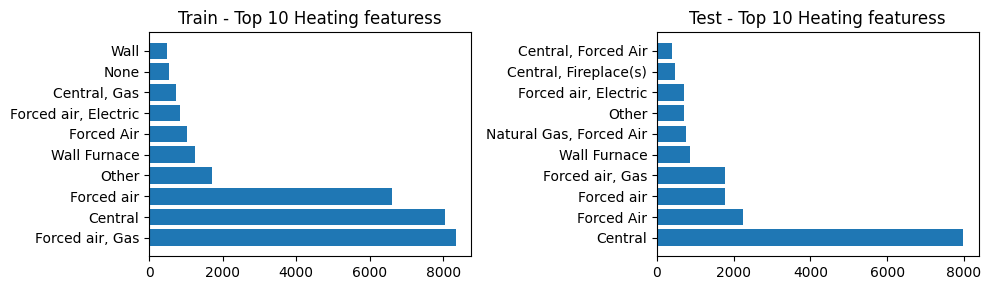

In [ ]:
plt.figure(figsize=(10, 3))
feature = 'Heating features'

train_counts = train[feature].value_counts().head(10)
test_counts = test[feature].value_counts().head(10)

plt.subplot(121); plt.barh(train_counts.index, train_counts.values); plt.title(f'Train - Top 10 {feature}s')
plt.subplot(122); plt.barh(test_counts.index, test_counts.values); plt.title(f'Test - Top 10 {feature}s')
plt.tight_layout();plt.show()

In [ ]:
# Clean Heating - Keyword
total1['Heating features'] = total1['Heating features'].str.title()
total1['Heating features'] = total1['Heating features'].str.replace('.*(Central).*?(Forced).*', 'Centra-Force', regex=True)
total1['Heating features'] = total1['Heating features'].str.replace('.*(Forced).*?(Central).*', 'Centra-Force', regex=True)
total1['Heating features'] = total1['Heating features'].str.replace('.*(Forced).*?(Electric).*', 'Force-E', regex=True)
total1['Heating features'] = total1['Heating features'].str.replace('.*(Electric).*?(Forced).*', 'Force-E', regex=True)
total1['Heating features'] = total1['Heating features'].str.replace('.*(Forced).*?(Gas).*', 'Force-G', regex=True)
total1['Heating features'] = total1['Heating features'].str.replace('.*(Gas).*?(Forced).*', 'Force-G', regex=True)
total1['Heating features'] = total1['Heating features'].str.replace('.*(Central).*?(Gas).*', 'Centra-G', regex=True)
total1['Heating features'] = total1['Heating features'].str.replace('.*(Gas).*?(Central).*', 'Centra-G', regex=True)
total1['Heating features'] = total1['Heating features'].str.replace('.*(Zoned).*', 'Zoned', regex=True)
total1['Heating features'] = total1['Heating features'].str.replace('.*(Forced).*', 'Forced', regex=True)
total1['Heating features'] = total1['Heating features'].str.replace('.*(Central).*', 'Central', regex=True)
total1['Heating features'] = total1['Heating features'].str.replace('.*(Wall).*', 'Wall', regex=True)
total1['Heating features'] = total1['Heating features'].str.replace('.*(Baseboard).*', 'Baseboard', regex=True)
total1['Heating features'] = total1['Heating features'].str.replace('.*(Floor).*', 'Floor', regex=True)
total1['Heating features'] = total1['Heating features'].str.replace('.*(Electric).*', 'Electric', regex=True)
total1['Heating features'] = total1['Heating features'].str.replace('.*(Gas).*', 'Gas', regex=True)
total1['Heating features'] = total1['Heating features'].str.replace('.*(Heat Pump).*', 'Pump', regex=True)
total1['Heating features'] = total1['Heating features'].str.replace('.*(Radiant).*', 'Radiant', regex=True)
total1['Heating features'] = total1['Heating features'].str.replace('.*(None).*', 'None', regex=True)
valid_heating = ['Centra-Force', 'Force-E', 'Force-G', 'Centra-G', 'Zoned', 'Forced', 'Central', 'Wall', 'Baseboard', 'Floor', 'Electric', 'Gas', 'Pump', 'Radiant', 'None']
total1["Heating features"] = total1["Heating features"].apply(lambda x: x if x in valid_heating else "Other")

df_heating = pd.DataFrame()
df_heating['Counts'] = total1['Heating features'].value_counts().head(50)
df_heating['List Mean'] = round(total1.groupby('Heating features')['Listed Price'].mean(),0)
df_heating['List Std'] = round(total1.groupby('Heating features')['Listed Price'].std(),0)
print(df_heating)

              Counts  List Mean   List Std
Central        17606  1303054.0  2098705.0
Other          16034   953584.0  3464131.0
Forced         13803  1146693.0  1768706.0
Force-G        12894  1362505.0  1428266.0
Wall            4021   720064.0   650929.0
Force-E         3531   766195.0  1120088.0
Gas             2050  1109055.0  1066967.0
Centra-G        1792  1295966.0  1137142.0
Electric        1551   828460.0  1372576.0
Centra-Force    1482  1072956.0  1240440.0
None            1040   995035.0  1892022.0
Baseboard       1011   850459.0   737179.0
Radiant          754  2017166.0  2825366.0
Zoned            677  1940584.0  2227792.0
Floor            536   881802.0   621707.0
Pump             283   528124.0   558305.0


### 3.4 Cooling features

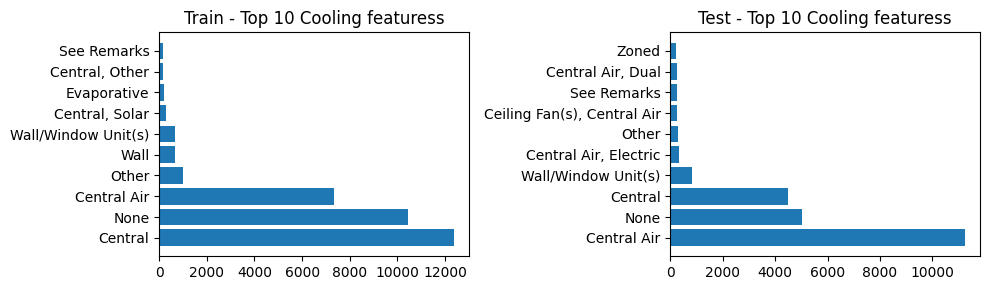

In [ ]:
plt.figure(figsize=(10, 3))
feature = 'Cooling features'

train_counts = train[feature].value_counts().head(10)
test_counts = test[feature].value_counts().head(10)

plt.subplot(121); plt.barh(train_counts.index, train_counts.values); plt.title(f'Train - Top 10 {feature}s')
plt.subplot(122); plt.barh(test_counts.index, test_counts.values); plt.title(f'Test - Top 10 {feature}s')
plt.tight_layout();plt.show()

In [ ]:
# Clean Cooling - Keyword
total1['Cooling features'] = total1['Cooling features'].str.title()
total1['Cooling features'] = total1['Cooling features'].str.replace('.*Central Air.*', 'Centra-Air', regex=True)
total1['Cooling features'] = total1['Cooling features'].str.replace('.*Central.*', 'Centra', regex=True)
total1['Cooling features'] = total1['Cooling features'].str.replace('.*Fan.*', 'Ceiling Fan', regex=True)
total1['Cooling features'] = total1['Cooling features'].str.replace('.*Wall.*', 'Wall', regex=True)
total1['Cooling features'] = total1['Cooling features'].str.replace('.*Window.*', 'Wall', regex=True)
total1['Cooling features'] = total1['Cooling features'].str.replace('.*No Air.*', 'None', regex=True)
total1['Cooling features'] = total1['Cooling features'].str.replace('.*None.*', 'None', regex=True)
total1['Cooling features'] = total1['Cooling features'].str.replace('.*Evaporative.*', 'Evaporative', regex=True)
total1['Cooling features'] = total1['Cooling features'].str.replace('.*Zoned.*', 'Zoned', regex=True)
valid_cooling = ["Centra-Air", "Centra", "Ceiling Fan", "Wall", "None", "Evaporative", 'Zoned']
total1["Cooling features"] = total1["Cooling features"].apply(lambda x: x if x in valid_cooling else "Other")

df_cooling = pd.DataFrame()
df_cooling['Counts'] = total1['Cooling features'].value_counts()
df_cooling['List Mean'] = round(total1.groupby('Cooling features')['Listed Price'].mean(),0)
df_cooling['List Std'] = round(total1.groupby('Cooling features')['Listed Price'].std(),0)
print(df_cooling)

             Counts  List Mean   List Std
Centra-Air    21917  1183227.0  1935083.0
Other         19008  1146813.0  1494339.0
Centra        18054  1226947.0  1934556.0
None          15828  1061774.0  3352884.0
Wall           2613   716847.0   661471.0
Ceiling Fan     710  1059682.0   808217.0
Evaporative     585   321577.0   254375.0
Zoned           350  1567150.0  1528870.0


### 3.5 Laundry features

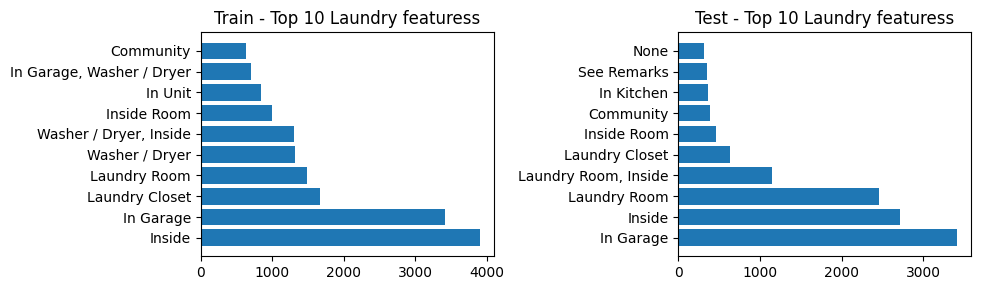

In [ ]:
plt.figure(figsize=(10, 3))
feature = 'Laundry features'

train_counts = train[feature].value_counts().head(10)
test_counts = test[feature].value_counts().head(10)

plt.subplot(121); plt.barh(train_counts.index, train_counts.values); plt.title(f'Train - Top 10 {feature}s')
plt.subplot(122); plt.barh(test_counts.index, test_counts.values); plt.title(f'Test - Top 10 {feature}s')
plt.tight_layout();plt.show()

In [ ]:
# Clean Laundry - Keyword
total1['Laundry features'] = total1['Laundry features'].str.title()
total1['Laundry features'] = total1['Laundry features'].str.replace('.*(Laundry Room).*', 'Laundry Room', regex=True)
total1['Laundry features'] = total1['Laundry features'].str.replace('.*(Closet).*', 'Closet', regex=True)
total1['Laundry features'] = total1['Laundry features'].str.replace('.*(Garage).*', 'Garage', regex=True)
total1['Laundry features'] = total1['Laundry features'].str.replace('.*(Kitchen).*', 'Kitchen', regex=True)
total1['Laundry features'] = total1['Laundry features'].str.replace('.*(Basement).*', 'Basement', regex=True)
total1['Laundry features'] = total1['Laundry features'].str.replace('.*(Utility).*', 'Utility', regex=True)
total1['Laundry features'] = total1['Laundry features'].str.replace('.*(Outside).*', 'Outside', regex=True)
total1['Laundry features'] = total1['Laundry features'].str.replace('.*(Inside).*', 'Inside', regex=True)
total1['Laundry features'] = total1['Laundry features'].str.replace('.*(In).*', 'Inside', regex=True)
total1['Laundry features'] = total1['Laundry features'].str.replace('.*(Hook).*', 'Hookup', regex=True)
total1['Laundry features'] = total1['Laundry features'].str.replace('.*(Washer).*?(Dryer).*', 'Wash-Dry', regex=True)
total1['Laundry features'] = total1['Laundry features'].str.replace('.*(Dryer).*?(Washer).*', 'Wash-Dry', regex=True)
total1['Laundry features'] = total1['Laundry features'].str.replace('.*(Com).*', 'Community', regex=True)
total1['Laundry features'] = total1['Laundry features'].str.replace('.*(Coin).*', 'Community', regex=True)

valid_laundary = ["Laundry Room", "Closet", "Garage", "Kitchen", "Basement", "Utility", "Outside",
                  "Inside", "Hookup", "Wash-Dry", "Community", "None"]
total1["Laundry features"] = total1["Laundry features"].apply(lambda x: x if x in valid_laundary else "Other")
total1['Laundry features'].value_counts()

df_laundary = pd.DataFrame()
df_laundary['Counts'] = total1['Laundry features'].value_counts()
df_laundary['List Mean'] = round(total1.groupby('Laundry features')['Listed Price'].mean(),0)
df_laundary['List Std'] = round(total1.groupby('Laundry features')['Listed Price'].std(),0)
print(df_laundary)

              Counts  List Mean    List Std
Other          22558  1087772.0   1664843.0
Inside         16503  1171072.0   1765454.0
Garage         11315   953456.0    671552.0
Laundry Room   10506  1413016.0   2473717.0
Closet          4250  1151772.0    999446.0
Hookup          3280   871936.0    812312.0
Utility         3033  1657197.0   1618839.0
Community       2120   793579.0    991998.0
Wash-Dry        1979  1333937.0   1741856.0
Kitchen         1533  1170554.0  10285759.0
Outside          862   681816.0    580264.0
None             807   816702.0   1691938.0
Basement         319  1279478.0    966978.0


### 3.6 Parking features

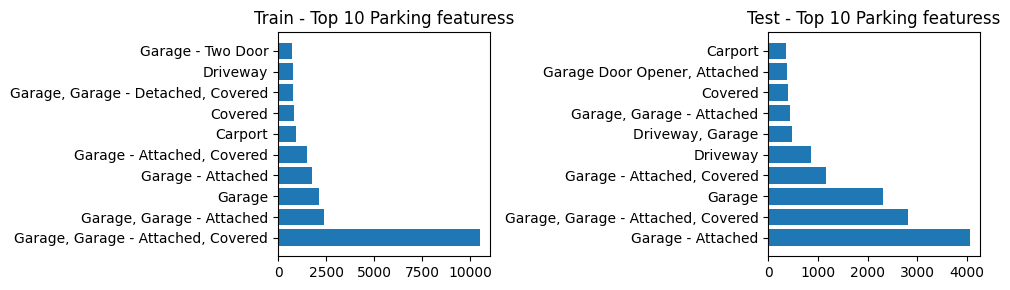

In [ ]:
plt.figure(figsize=(10, 3))
feature = 'Parking features'

train_counts = train[feature].value_counts().head(10)
test_counts = test[feature].value_counts().head(10)

plt.subplot(121); plt.barh(train_counts.index, train_counts.values); plt.title(f'Train - Top 10 {feature}s')
plt.subplot(122); plt.barh(test_counts.index, test_counts.values); plt.title(f'Test - Top 10 {feature}s')
plt.tight_layout();plt.show()

In [ ]:
# Clean Parking - Keyword
total1['Parking features'] = total1['Parking features'].str.title()
total1['Parking features'] = total1['Parking features'].str.replace('.*(Garage, Garage - Detached).*', 'GGDetach', regex=True)
total1['Parking features'] = total1['Parking features'].str.replace('.*(Garage, Garage - Attached).*', 'GGAttach', regex=True)
total1['Parking features'] = total1['Parking features'].str.replace('.*(Garage - Detached).*', 'GDetach', regex=True)
total1['Parking features'] = total1['Parking features'].str.replace('.*(Garage - Attached).*', 'GAttach', regex=True)
total1['Parking features'] = total1['Parking features'].str.replace('.*(Three Door).*', 'ThreeDoor', regex=True)
total1['Parking features'] = total1['Parking features'].str.replace('.*(Two Door).*', 'TwoDoor', regex=True)
total1['Parking features'] = total1['Parking features'].str.replace('.*(Single Door).*', 'SingleDoor', regex=True)
total1['Parking features'] = total1['Parking features'].str.replace('.*(Driveway).*', 'Driveway', regex=True)
total1['Parking features'] = total1['Parking features'].str.replace('.*(Off).*', 'OffStreet', regex=True)
total1['Parking features'] = total1['Parking features'].str.replace('.*(On Site).*', 'OnSite', regex=True)
total1['Parking features'] = total1['Parking features'].str.replace('.*(Assigned).*', 'Assigned', regex=True)
total1['Parking features'] = total1['Parking features'].str.replace('.*(Cover).*', 'Covered', regex=True)
total1['Parking features'] = total1['Parking features'].str.replace('.*(Detached).*', 'Detached', regex=True)
total1['Parking features'] = total1['Parking features'].str.replace('.*(Attached).*', 'Attached', regex=True)
total1['Parking features'] = total1['Parking features'].str.replace('.*(Garage).*', 'Garage', regex=True)
total1['Parking features'] = total1['Parking features'].str.replace('.*(Carport).*', 'Carport', regex=True)
total1['Parking features'] = total1['Parking features'].str.replace('.*(None).*', 'None', regex=True)
valid_parking = ["GGDetach", "GGAttach", "GDetach", "GAttach", "ThreeDoor", "TwoDoor", "SingleDoor", "Driveway", "OffStreet",
                 "OnSite", "Assigned", "Detached", "Attached", "Garage", "Carport", "Covered", "None"]
total1["Parking features"] = total1["Parking features"].apply(lambda x: x if x in valid_parking else "Other")

df_parking = pd.DataFrame()
df_parking['Counts'] = total1['Parking features'].value_counts()
df_parking['List Mean'] = round(total1.groupby('Parking features')['Listed Price'].mean(),0)
df_parking['List Std'] = round(total1.groupby('Parking features')['Listed Price'].std(),0)
print(df_parking.head(50))

            Counts  List Mean    List Std
GGAttach     17012  1351166.0   1491075.0
GAttach      10359   951032.0   1416295.0
Other         9427   880866.0   1882746.0
Driveway      8384  1270082.0   1952938.0
Garage        7320   903006.0   1427518.0
TwoDoor       4372  1608840.0   1827511.0
Covered       3378   955262.0   1819132.0
OnSite        2988  1558056.0   1193930.0
Attached      2620  1159000.0   1286680.0
SingleDoor    2433   863838.0    718672.0
Assigned      2271   784737.0    700639.0
GGDetach      1717  1293793.0   1542965.0
GDetach       1648   781623.0   1211019.0
OffStreet     1582   944677.0    805414.0
Carport       1521   681923.0    972116.0
Detached       764  1714092.0  14566621.0
None           722   885224.0    642272.0
ThreeDoor      547  3334418.0   5885897.0


### 3.7 Appliances included

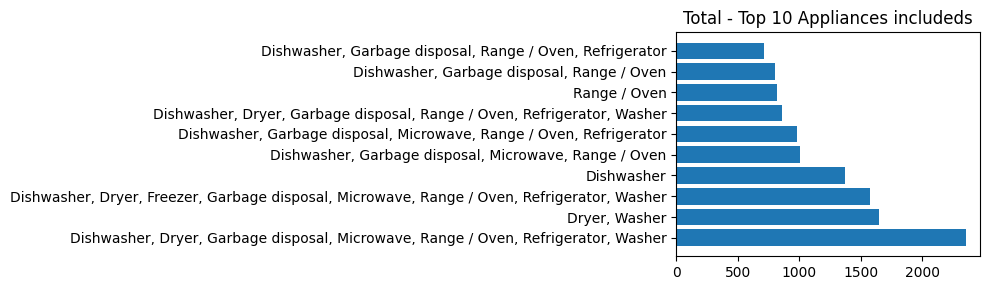

In [ ]:
plt.figure(figsize=(10, 3))
feature = 'Appliances included'

total_counts = total1[feature].value_counts().head(10)
plt.subplot(111); plt.barh(total_counts.index, total_counts.values); plt.title(f'Total - Top 10 {feature}s')
plt.tight_layout();plt.show()

In [ ]:
# Clean Appliances - Count
total1['Appliances included'] = total1['Appliances included'].str.count(',') + 1
total1['Appliances included'] = total1['Appliances included'].astype('float64')
total1['Appliances included'] = total1['Appliances included'].apply(lambda x: 10 if x >= 10 else x)
total1['Appliances included'].value_counts()

4.0     8603
3.0     8553
2.0     8102
5.0     7230
6.0     6345
7.0     5263
1.0     5211
8.0     3412
10.0    1688
9.0     1309
Name: Appliances included, dtype: int64

---
# 4. Data Cleaning - Time and Location Features

In [ ]:
col_remove = ["Address", "Summary", "Elementary School", "Middle School", "High School", "City", "Region", "State", "Heating", "Cooling", "Parking"]
total2 = total1.copy()
total2 = total2.drop(columns=col_remove)

total2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 79065 entries, 0 to 31625
Data columns (total 30 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Id                           79065 non-null  int64  
 1   Sold Price                   47439 non-null  float64
 2   Type                         79065 non-null  object 
 3   Year built                   77123 non-null  float64
 4   Lot                          56076 non-null  float64
 5   Bedrooms                     74467 non-null  object 
 6   Bathrooms                    73655 non-null  float64
 7   Full bathrooms               66137 non-null  float64
 8   Total interior livable area  75187 non-null  float64
 9   Total spaces                 77398 non-null  float64
 10  Garage spaces                77398 non-null  float64
 11  Elementary School Score      70330 non-null  float64
 12  Elementary School Distance   70572 non-null  float64
 13  Middle School Sc

### 4.1 Year built

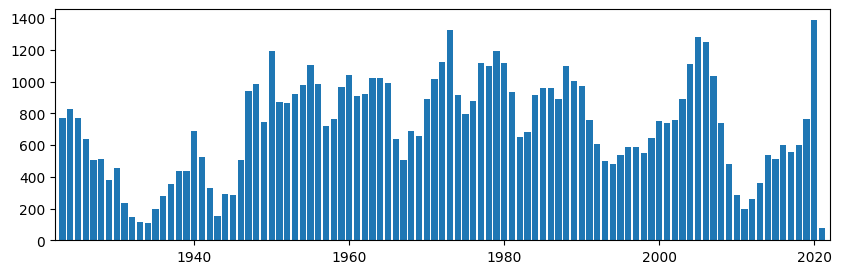

In [ ]:
# Year built - Clean Outliers
total2['Year built'] = np.where(total2['Year built'] < 1923, np.nan, total2['Year built'])
total2['Year built'] = np.where(total2['Year built'] >= 2022, np.nan, total2['Year built'])
total2['Year built'] = total2['Year built'].astype('float64')

plt.figure(figsize=(10, 3))
counts = total2['Year built'].value_counts()
plt.bar(counts.index, counts.values)
plt.xlim(1922, max(counts.index)+1)
plt.show()

### 4.2 Year Listed

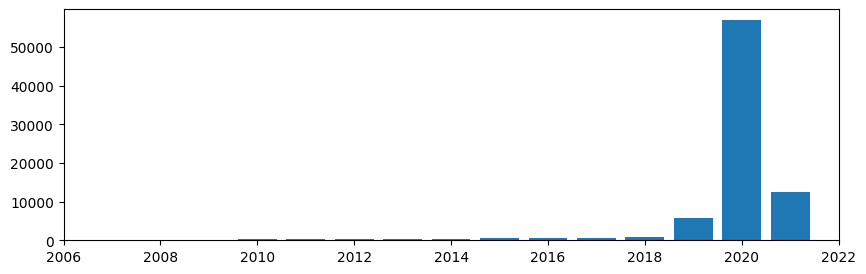

In [ ]:
total2['Listed On'] = pd.to_datetime(total2['Listed On'])
total2['Listed On'] = total2['Listed On'].dt.year.astype('float')

plt.figure(figsize=(10, 3))
counts = total2['Listed On'].value_counts()
plt.bar(counts.index, counts.values)
plt.xlim(min(counts.index)-1, max(counts.index)+1)
plt.show()

### 4.3 Year Sold

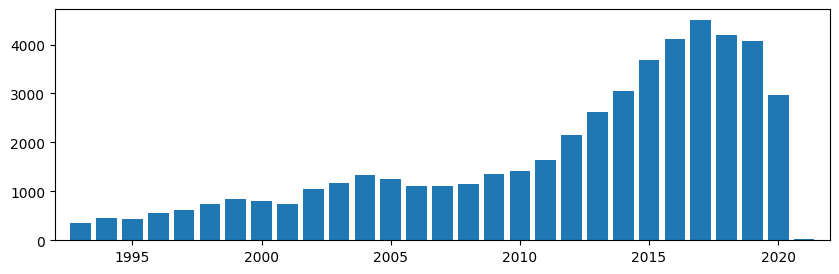

In [ ]:
total2['Last Sold On'] = pd.to_datetime(total2['Last Sold On'])
total2['Last Sold On'] = total2['Last Sold On'].dt.year.astype('float')
total2['Last Sold On'] = np.where(total2['Last Sold On'] <= 1993, 1993, total2['Last Sold On'])

plt.figure(figsize=(10, 3))
counts = total2['Last Sold On'].value_counts()
plt.bar(counts.index, counts.values)
plt.xlim(min(counts.index)-1, max(counts.index)+1)
plt.show()

### 4.4 Zip Code

In [ ]:
total2['Zip'] = (total2['Zip'] / 100).astype(int)
total2['Zip'] = total2['Zip'].astype(str)
total2['Zip'].isna().sum()

0

### 4.5 Schools

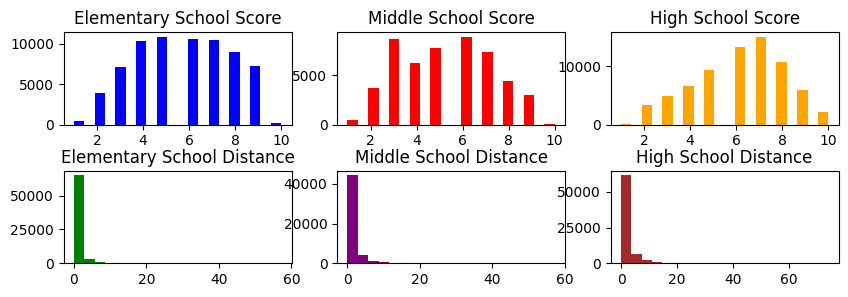

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(10, 3))
fig.subplots_adjust(hspace=0.5)

axs[0, 0].hist(total2['Elementary School Score'], bins=20, color='blue')
axs[0, 0].set_title('Elementary School Score')
axs[1, 0].hist(total2['Elementary School Distance'], bins=20, color='green')
axs[1, 0].set_title('Elementary School Distance')
axs[0, 1].hist(total2['Middle School Score'], bins=20, color='red')
axs[0, 1].set_title('Middle School Score')
axs[1, 1].hist(total2['Middle School Distance'], bins=20, color='purple')
axs[1, 1].set_title('Middle School Distance')
axs[0, 2].hist(total2['High School Score'], bins=20, color='orange')
axs[0, 2].set_title('High School Score')
axs[1, 2].hist(total2['High School Distance'], bins=20, color='brown')
axs[1, 2].set_title('High School Distance')
plt.show()

---
# 5. Data Cleaning - Numerical Features

- Building: Lot, Interior, Garage, and Space
- Rooms: Bathrooms, Bedrooms, and Full Bath
- Estimation: List Price, Last Sold Price, Tax amount and Tax Value

In [ ]:
total3 = total2.copy()
total3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 79065 entries, 0 to 31625
Data columns (total 30 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Id                           79065 non-null  int64  
 1   Sold Price                   47439 non-null  float64
 2   Type                         79065 non-null  object 
 3   Year built                   71334 non-null  float64
 4   Lot                          56076 non-null  float64
 5   Bedrooms                     74467 non-null  object 
 6   Bathrooms                    73655 non-null  float64
 7   Full bathrooms               66137 non-null  float64
 8   Total interior livable area  75187 non-null  float64
 9   Total spaces                 77398 non-null  float64
 10  Garage spaces                77398 non-null  float64
 11  Elementary School Score      70330 non-null  float64
 12  Elementary School Distance   70572 non-null  float64
 13  Middle School Sc

### 5.1 Building

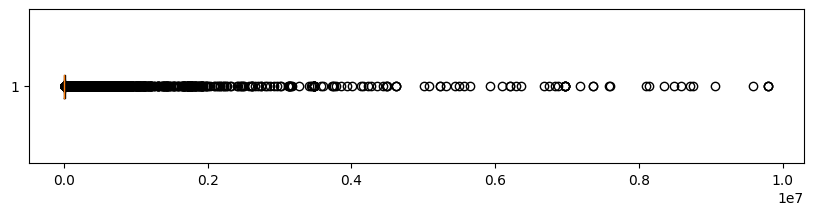

In [ ]:
total3['Lot'] = np.where(total3['Lot'] <= 100, np.nan, total3['Lot'])
total3['Lot'] = np.where(total3['Lot'] >= 9999999, np.nan, total3['Lot'])

plt.figure(figsize=(10, 2))
total3_cleaned = total3.dropna(subset=['Lot'])
plt.boxplot(total3_cleaned['Lot'], vert=False)
plt.show()

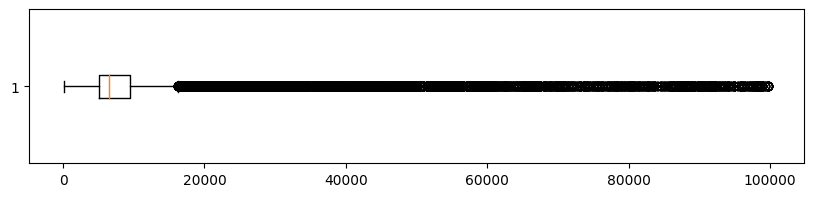

In [ ]:
total3['Total interior livable area'] = np.where(total3['Total interior livable area'] <= 200, np.nan, total3['Lot'])
total3['Total interior livable area'] = np.where(total3['Total interior livable area'] >= 100000, np.nan, total3['Lot'])

plt.figure(figsize=(10, 2))
total3_cleaned = total3.dropna(subset=['Total interior livable area'])
plt.boxplot(total3_cleaned['Total interior livable area'], vert=False)
plt.show()

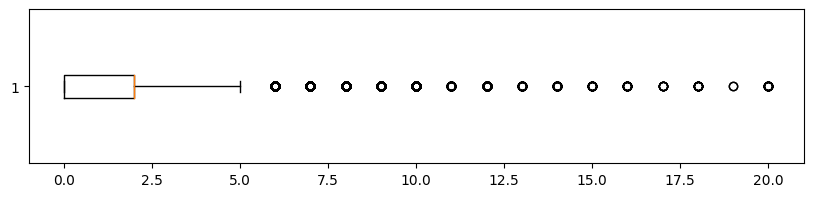

In [ ]:
total3.loc[total3['Total spaces'] < 0, 'Total spaces'] = np.nan
total3.loc[total3['Total spaces'] > 20, 'Total spaces'] = np.nan

plt.figure(figsize=(10, 2))
total3_cleaned = total3.dropna(subset=['Total spaces'])
plt.boxplot(total3_cleaned['Total spaces'], vert=False)
plt.show()

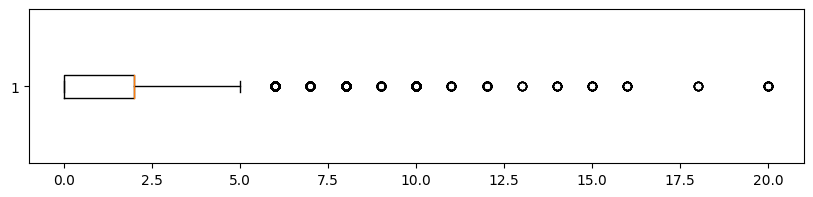

In [ ]:
total3.loc[total3['Garage spaces'] < 0, 'Garage spaces'] = np.nan
total3.loc[total3['Garage spaces'] > 20, 'Garage spaces'] = np.nan

plt.figure(figsize=(10, 2))
total3_cleaned = total3.dropna(subset=['Garage spaces'])
plt.boxplot(total3_cleaned['Garage spaces'], vert=False)
plt.show()

### 5.2 Rooms

In [ ]:
total3['Bedrooms'] = total3['Bedrooms'].str.replace('Suite', 'Bedroom', regex=True)
total3['Bedrooms'] = total3['Bedrooms'].str.replace(', More than One.*', '', regex=True)
total3['Bedrooms'] = total3['Bedrooms'].str.replace('.*(Bedroom).*?(Bedroom).*?(Bedroom).*?(Bedroom).*', '4', regex=True)
total3['Bedrooms'] = total3['Bedrooms'].str.replace('.*(Bedroom).*?(Bedroom).*?(Bedroom).*', '3', regex=True)
total3['Bedrooms'] = total3['Bedrooms'].str.replace('.*(Bedroom).*?(Bedroom).*', '2', regex=True)
total3['Bedrooms'] = total3['Bedrooms'].str.replace('.*(Bedroom).*', '1', regex=True)
total3['Bedrooms'] = total3['Bedrooms'].str.replace('.*( ).*', '0', regex=True)
total3['Bedrooms'] = total3['Bedrooms'].astype('float64')

total3['Bedrooms'] = total3['Bedrooms'].apply(lambda x: 10 if x >= 10 else x)
total3['Bedrooms'].value_counts()

3.0     27544
2.0     17462
4.0     14064
1.0      8179
5.0      4004
0.0      1835
6.0       888
7.0       217
8.0       112
10.0      111
9.0        51
Name: Bedrooms, dtype: int64

In [ ]:
total3['Bathrooms'] = total3['Bathrooms'].apply(lambda x: 10 if x >= 10 else x)
total3['Bathrooms'].value_counts()

2.0     32814
3.0     20154
1.0     11936
4.0      4938
5.0      1738
6.0       770
0.0       705
7.0       284
8.0       144
10.0      108
9.0        64
Name: Bathrooms, dtype: int64

In [ ]:
total3['Full bathrooms'] = total3['Bathrooms'].apply(lambda x: 10 if x >= 10 else x)
total3['Full bathrooms'].value_counts()

2.0     32814
3.0     20154
1.0     11936
4.0      4938
5.0      1738
6.0       770
0.0       705
7.0       284
8.0       144
10.0      108
9.0        64
Name: Full bathrooms, dtype: int64

In [ ]:
total3['Full bathrooms'] = total3['Bathrooms'].apply(lambda x: 10 if x >= 10 else x)
total3['Full bathrooms'].value_counts()

2.0     32814
3.0     20154
1.0     11936
4.0      4938
5.0      1738
6.0       770
0.0       705
7.0       284
8.0       144
10.0      108
9.0        64
Name: Full bathrooms, dtype: int64

### 5.3 Estimation

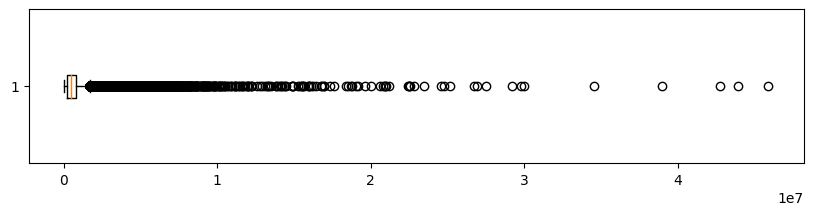

In [ ]:
total3.loc[total3['Tax assessed value'] < 1000, 'Tax assessed value'] = np.nan
total3.loc[total3['Tax assessed value'] > 50000000, 'Tax assessed value'] = np.nan

plt.figure(figsize=(10, 2))
total3_cleaned = total3.dropna(subset=['Tax assessed value'])
plt.boxplot(total3_cleaned['Tax assessed value'], vert=False)
plt.show()

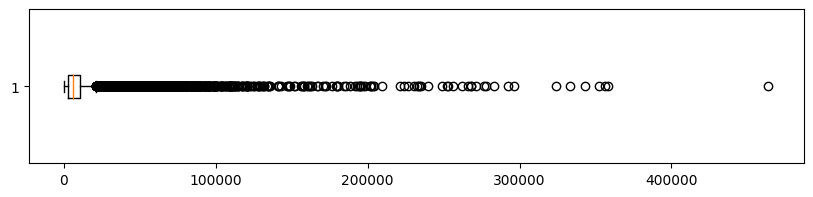

In [ ]:
total3.loc[total3['Annual tax amount'] < 100, 'Annual tax amount'] = np.nan
total3.loc[total3['Annual tax amount'] > 500000, 'Annual tax amount'] = np.nan

plt.figure(figsize=(10, 2))
total3_cleaned = total3.dropna(subset=['Annual tax amount'])
plt.boxplot(total3_cleaned['Annual tax amount'], vert=False)
plt.show()

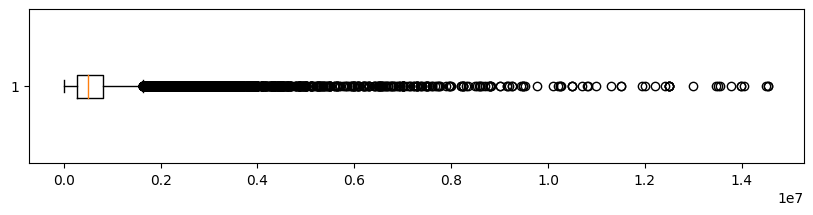

In [ ]:
total3.loc[total3['Last Sold Price'] < 1000, 'Last Sold Price'] = np.nan
total3.loc[total3['Last Sold Price'] > 15000000, 'Last Sold Price'] = np.nan

plt.figure(figsize=(10, 2))
total3_cleaned = total3.dropna(subset=['Last Sold Price'])
plt.boxplot(total3_cleaned['Last Sold Price'], vert=False)
plt.show()

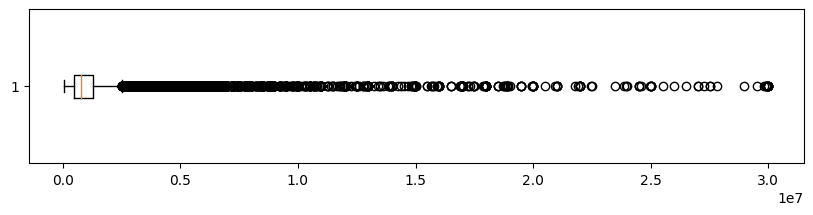

In [ ]:
total3.loc[total3['Listed Price'] < 50000, 'Listed Price'] = np.nan
total3.loc[total3['Listed Price'] > 30000000, 'Listed Price'] = np.nan

plt.figure(figsize=(10, 2))
total3_cleaned = total3.dropna(subset=['Listed Price'])
plt.boxplot(total3_cleaned['Listed Price'], vert=False)
plt.show()

In [ ]:
total3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 79065 entries, 0 to 31625
Data columns (total 30 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Id                           79065 non-null  int64  
 1   Sold Price                   47439 non-null  float64
 2   Type                         79065 non-null  object 
 3   Year built                   71334 non-null  float64
 4   Lot                          55384 non-null  float64
 5   Bedrooms                     74467 non-null  float64
 6   Bathrooms                    73655 non-null  float64
 7   Full bathrooms               73655 non-null  float64
 8   Total interior livable area  52049 non-null  float64
 9   Total spaces                 77303 non-null  float64
 10  Garage spaces                77342 non-null  float64
 11  Elementary School Score      70330 non-null  float64
 12  Elementary School Distance   70572 non-null  float64
 13  Middle School Sc

---
# 5. Guessing

In [ ]:
total4 = total3.copy()

In [ ]:
numerical_columns = total4.select_dtypes(include=['float']).drop(columns=['Sold Price'])
total4[numerical_columns.columns] = total4[numerical_columns.columns].fillna(0)
total4.nunique()

Id                             79065
Sold Price                      5627
Type                               7
Year built                       100
Lot                            11807
Bedrooms                          11
Bathrooms                         11
Full bathrooms                    11
Total interior livable area    10247
Total spaces                      21
Garage spaces                     19
Elementary School Score           11
Elementary School Distance       268
Middle School Score               11
Middle School Distance           254
High School Score                 11
High School Distance             359
Flooring                          10
Heating features                  16
Cooling features                   8
Appliances included               11
Laundry features                  13
Parking features                  18
Tax assessed value             54534
Annual tax amount              21267
Listed On                         15
Listed Price                    6281
L

In [ ]:
object_columns = total4.select_dtypes(include=['object']).columns
total1_encoded = pd.get_dummies(total4, columns=object_columns, drop_first=True)

columns_to_log = ['Lot', 'Total interior livable area', 'Tax assessed value', 'Annual tax amount', 'Last Sold Price', 'Listed Price']
total1_encoded[columns_to_log] = np.log1p(total1_encoded[columns_to_log])

i = total1_encoded.shape[0] - test.shape[0]
train_data = total1_encoded[:i]
test_data = total1_encoded[i:]

print("train",train_data.shape)
print("test",test_data.shape)

from sklearn.model_selection import train_test_split
train_noid = train_data.drop('Id', axis=1)
X_train, X_val, y_train, y_val = train_test_split(train_noid.drop('Sold Price', axis=1), train_noid['Sold Price'], test_size=0.1, random_state=26)
print("X_train",X_train.shape)
print("X_val",X_val.shape)
print("y_train",y_train.shape)
print("y_val",y_val.shape)

y_train_log = np.log1p(y_train)
y_val_log = np.log1p(y_val)

train (47439, 146)
test (31626, 146)
X_train (42695, 144)
X_val (4744, 144)
y_train (42695,)
y_val (4744,)


In [ ]:
### guessing by Listed Price

y_train_pred = np.expm1(X_train['Listed Price'])
y_train_rmse = np.mean(np.abs(y_train_pred - y_train) / y_train)

y_val_pred = np.expm1(X_val['Listed Price'])
y_val_rmse = np.mean(np.abs(y_val_pred - y_val) / y_val)

print("y_train log_RMSE:", y_train_rmse)
print("y_val log_RMSE:", y_val_rmse)

y_train log_RMSE: 0.11597738958479806
y_val log_RMSE: 0.12381921683401578
y_val2 log_RMSE: 0.12323031337701595


In [ ]:
y_pred_test = (test_data['Listed Price'])
result_df = pd.DataFrame({'Id': test_data['Id'], 'Sold Price': y_pred_test})
result_df.to_csv('Listed.csv', index=False)

In [ ]:
y_train_pred = np.expm1(X_train['Listed Price']).apply(lambda x: 150000 if x < 150000 else x)
y_train_rmse2 = np.mean(np.abs(y_train_pred - y_train) / y_train)

y_val_pred = np.expm1(X_val['Listed Price']).apply(lambda x: 150000 if x < 150000 else x)
y_val_rmse2 = np.mean(np.abs(y_val_pred - y_val) / y_val)

print("y_train log_RMSE:", y_train_rmse2)
print("y_val log_RMSE:", y_val_rmse2)

y_train log_RMSE: 0.11511979427242684
y_val log_RMSE: 0.12323031337701595


In [ ]:
y_pred_test = np.expm1(test_data['Listed Price']).apply(lambda x: 150000 if x < 150000 else x)
result_df = pd.DataFrame({'Id': test_data['Id'], 'Sold Price': y_pred_test})
result_df.to_csv('Listed Adj.csv', index=False)

# 7. Random Forest Modeling

In [ ]:
### Random Forest Model
from sklearn.ensemble import RandomForestRegressor

rf_default_model = RandomForestRegressor(random_state=26)
rf_default_model.fit(X_train, y_train_log)

y_train_pred = rf_default_model.predict(X_train)
y_train_rmse = np.mean(np.abs(np.expm1(y_train_pred) - y_train) / y_train)

y_val_pred = rf_default_model.predict(X_val)
y_val_rmse = np.mean(np.abs(np.expm1(y_val_pred) - y_val) / y_val)

print("y_train log_RMSE:", y_train_rmse)
print("y_val log_RMSE:", y_val_rmse)

y_train log_RMSE: 0.03578632811290064
y_val log_RMSE: 0.11736721642475959


In [ ]:
rf_default_model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 26,
 'verbose': 0,
 'warm_start': False}

In [ ]:
y_pred_test = rf_default_model.predict(test_data.drop(['Id', 'Sold Price'], axis=1))
y_pred_test = np.expm1(y_pred_test)
result_df = pd.DataFrame({'Id': test_data['Id'], 'Sold Price': y_pred_test})
result_df.to_csv('x.csv', index=False)

In [ ]:
### Random Forest Model
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(
                  n_estimators=600,   # 100,200,300,400,500,600,700
                  max_depth=18,     # 10,12,14,16,18,20
                  min_samples_leaf=9,  # 1,3,5,7,9,11
                  random_state=26
                  )
rf_model.fit(X_train, y_train_log)

y_train_pred = rf_model.predict(X_train)
y_train_rmse = np.mean(np.abs(np.expm1(y_train_pred) - y_train) / y_train)

y_val_pred = rf_model.predict(X_val)
y_val_rmse = np.mean(np.abs(np.expm1(y_val_pred) - y_val) / y_val)

print("y_train log_RMSE:", y_train_rmse)
print("y_val log_RMSE:", y_val_rmse)

y_train log_RMSE: 0.08056825943879646
y_val log_RMSE: 0.11420254767903028


In [ ]:
rf_model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 18,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 9,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 600,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 26,
 'verbose': 0,
 'warm_start': False}

In [ ]:
y_pred_test = rf_model.predict(test_data.drop(['Id', 'Sold Price'], axis=1))
y_pred_test = np.expm1(y_pred_test)
result_df = pd.DataFrame({'Id': test_data['Id'], 'Sold Price': y_pred_test})
result_df.to_csv('xx.csv', index=False)

In [ ]:
feature_importance = rf_model.feature_importances_
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
feature_importance_df['Importance'] = feature_importance_df['Importance'] * 100
print(round(feature_importance_df.sort_values(by='Importance', ascending=False),2).head(50))

                         Feature  Importance
18                  Listed Price       94.38
15            Tax assessed value        2.28
17                     Listed On        0.68
16             Annual tax amount        0.44
20               Last Sold Price        0.28
4                 Full bathrooms        0.25
3                      Bathrooms        0.23
0                     Year built        0.15
5    Total interior livable area        0.13
13          High School Distance        0.11
1                            Lot        0.10
19                  Last Sold On        0.10
9     Elementary School Distance        0.08
8        Elementary School Score        0.08
87                       Zip_900        0.08
11        Middle School Distance        0.07
12             High School Score        0.06
14           Appliances included        0.06
77     Parking features_GGAttach        0.05
2                       Bedrooms        0.04
10           Middle School Score        0.04
133       

# 8. Catboost Modeling

In [ ]:
pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 17.6 MB/s eta 0:00:00


In [ ]:
total5 = total3.copy()

In [ ]:
object_columns = total5.select_dtypes(include=['object']).columns
total1_encoded = pd.get_dummies(total5, columns=object_columns, drop_first=True)

columns_to_log = ['Lot', 'Total interior livable area', 'Tax assessed value', 'Annual tax amount', 'Last Sold Price', 'Listed Price']
total1_encoded[columns_to_log] = np.log1p(total1_encoded[columns_to_log])

i = total1_encoded.shape[0] - test.shape[0]
train_data = total1_encoded[:i]
test_data = total1_encoded[i:]

print("train",train_data.shape)
print("test",test_data.shape)

from sklearn.model_selection import train_test_split
train_noid = train_data.drop('Id', axis=1)
X_train, X_val, y_train, y_val = train_test_split(train_noid.drop('Sold Price', axis=1), train_noid['Sold Price'], test_size=0.1, random_state=26)
print("X_train",X_train.shape)
print("X_val",X_val.shape)
print("y_train",y_train.shape)
print("y_val",y_val.shape)

y_train_log = np.log1p(y_train)
y_val_log = np.log1p(y_val)

train (47439, 146)
test (31626, 146)
X_train (42695, 144)
X_val (4744, 144)
y_train (42695,)
y_val (4744,)


In [ ]:
from catboost import CatBoostRegressor

cb_default_model = CatBoostRegressor(random_state=26, verbose=False)
cb_default_model.fit(X_train, y_train_log)

y_train_pred = cb_default_model.predict(X_train)
y_train_rmse = np.mean(np.abs(np.expm1(y_train_pred) - y_train) / y_train)

y_val_pred = cb_default_model.predict(X_val)
y_val_rmse = np.mean(np.abs(np.expm1(y_val_pred) - y_val) / y_val)

print("y_train log_RMSE:", y_train_rmse)
print("y_val log_RMSE:", y_val_rmse)

y_train log_RMSE: 0.08235756407401727
y_val log_RMSE: 0.10884989326267268


In [ ]:
cb_default_model.get_all_params()

{'nan_mode': 'Min',
 'eval_metric': 'RMSE',
 'iterations': 1000,
 'sampling_frequency': 'PerTree',
 'leaf_estimation_method': 'Newton',
 'random_score_type': 'NormalWithModelSizeDecrease',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'bayesian_matrix_reg': 0.10000000149011612,
 'eval_fraction': 0,
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': True,
 'model_size_reg': 0.5,
 'pool_metainfo_options': {'tags': {}},
 'subsample': 0.800000011920929,
 'use_best_model': False,
 'random_seed': 26,
 'depth': 6,
 'posterior_sampling': False,
 'border_count': 254,
 'classes_count': 0,
 'auto_class_weights': 'None',
 'sparse_features_conflict_fraction': 0,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'best_model_min_trees': 1,
 'model_shrink_rate': 0,
 'min_data_in_leaf': 1,
 'loss_function': 'RMSE',
 'lea

In [ ]:
y_pred_test = cb_default_model.predict(test_data.drop(['Id', 'Sold Price'], axis=1))
y_pred_test = np.expm1(y_pred_test)
result_df = pd.DataFrame({'Id': test_data['Id'], 'Sold Price': y_pred_test})
result_df.to_csv('xx1.csv', index=False)

In [ ]:
from catboost import CatBoostRegressor
# 0.1070919556335067 0.1055985859507202 0.10508734795077881 0.10495189697751259
cb_model = CatBoostRegressor(
                iterations=1700,      # 1000 1500 1700
                learning_rate=0.023,    # 0.01 0.02 0.03
                depth=10,         # 6 7 8 9 10
                random_state=26,
                verbose=False
                )
cb_model.fit(X_train, y_train_log)

y_train_pred = cb_model.predict(X_train)
y_train_rmse = np.mean(np.abs(np.expm1(y_train_pred) - y_train) / y_train)

y_val_pred = cb_model.predict(X_val)
y_val_rmse = np.mean(np.abs(np.expm1(y_val_pred) - y_val) / y_val)

print("y_train log_RMSE:", y_train_rmse)
print("y_val log_RMSE:", y_val_rmse)

y_train log_RMSE: 0.0696923929553575
y_val log_RMSE: 0.10514516006194641


In [ ]:
cb_model.get_all_params()

{'nan_mode': 'Min',
 'eval_metric': 'RMSE',
 'iterations': 1700,
 'sampling_frequency': 'PerTree',
 'leaf_estimation_method': 'Newton',
 'random_score_type': 'NormalWithModelSizeDecrease',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'bayesian_matrix_reg': 0.10000000149011612,
 'eval_fraction': 0,
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': True,
 'model_size_reg': 0.5,
 'pool_metainfo_options': {'tags': {}},
 'subsample': 0.800000011920929,
 'use_best_model': False,
 'random_seed': 26,
 'depth': 10,
 'posterior_sampling': False,
 'border_count': 254,
 'classes_count': 0,
 'auto_class_weights': 'None',
 'sparse_features_conflict_fraction': 0,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'best_model_min_trees': 1,
 'model_shrink_rate': 0,
 'min_data_in_leaf': 1,
 'loss_function': 'RMSE',
 'le

In [ ]:
y_pred_test = cb_model.predict(test_data.drop(['Id', 'Sold Price'], axis=1))
y_pred_test = np.expm1(y_pred_test)
result_df = pd.DataFrame({'Id': test_data['Id'], 'Sold Price': y_pred_test})
result_df.to_csv('Catboost27.csv', index=False)

In [ ]:
feature_importance = cb_model.get_feature_importance(type="FeatureImportance")
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
print(round(feature_importance_df.sort_values(by='Importance', ascending=False),2).head(50))

                         Feature  Importance
18                  Listed Price       62.24
17                     Listed On        7.03
15            Tax assessed value        4.34
16             Annual tax amount        3.93
20               Last Sold Price        2.02
19                  Last Sold On        1.79
0                     Year built        1.62
3                      Bathrooms        1.40
5    Total interior livable area        1.19
87                       Zip_900        1.06
13          High School Distance        0.92
4                 Full bathrooms        0.92
133                      Zip_951        0.88
9     Elementary School Distance        0.88
1                            Lot        0.77
11        Middle School Distance        0.76
12             High School Score        0.72
8        Elementary School Score        0.70
10           Middle School Score        0.61
14           Appliances included        0.60
2                       Bedrooms        0.47
77     Par